## 1.明确目的
1.分析每个变量以及变量的重要程度  
2.研究主要特征, Saleprice  
3.研究其他变量对主要变量的影响  
4.对一些缺失数据，异常数据进行处理

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew 

In [2]:
#导入数据
train=pd.read_csv(r'e:\data\train.csv')
test=pd.read_csv(r'e:\data\test.csv')
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


共81个特征

In [3]:
#检查变量名
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 2. 分析预测变量'SalePrice'

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

SalePrice skewness: 1.882876


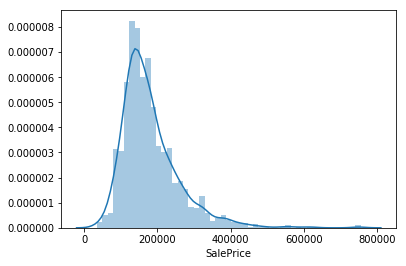

In [5]:
sns.distplot(train['SalePrice'])
print("SalePrice skewness: %f"%train['SalePrice'].skew())

Saleprice没有缺失值或是0数值, 偏斜度1.88，正偏斜。显然不是最佳模型，所以要进行log转换。

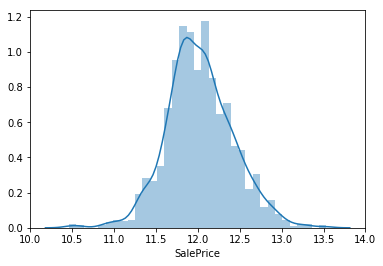

In [6]:
saleprice_log=np.log(train['SalePrice'])
sns.distplot(saleprice_log)
saleprice_log.skew()
train['SalePrice_log']=saleprice_log

转换后偏度减少到0.12，接近于正态分布。

## 3.数值型变量和字符型变量

In [7]:
num_feats = train.dtypes[train.dtypes != "object"].index
cat_feats=train.dtypes[train.dtypes == "object"].index
print("Numerical features: ",num_feats)
print('\n')
print("Categorical features: ", cat_feats)

Numerical features:  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice_log'],
      dtype='object')


Categorical features:  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'Bsm

In [8]:
num_feats

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice_log'],
      dtype='object')

## 3.数值变量分析

### (1) 特征选择

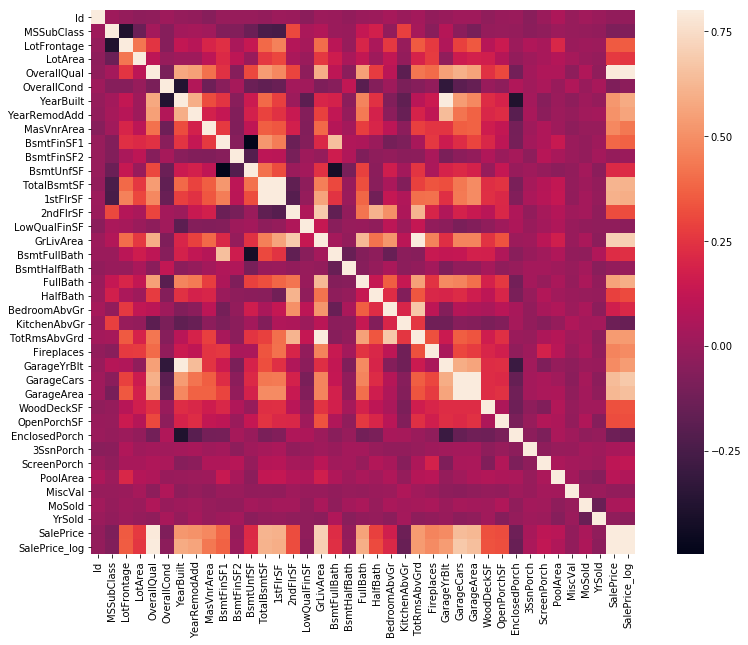

In [9]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(train[num_feats].corr(),vmax=0.8,square=True,cbar=True)

根据色深来判断'TotalBsmtSF和'1stFlrSF'以及'GarageX'和'GarageArea'存在很强的相关性。至于SalePrice,观察和OverallQual有明显关联。

In [10]:
corrmat=train[num_feats].corr()

In [11]:
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_log
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917,-0.017942
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284,-0.073959
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799,0.355878
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843,0.257320
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982,0.817184
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856,-0.036868
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897,0.586570
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101,0.565608
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493,0.430809
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420,0.372023


In [12]:
cols=corrmat['SalePrice_log'].abs().sort_values(ascending=False)[0:10]

In [13]:
train_num=train[cols.index].drop(['GarageCars','1stFlrSF'],axis=1)
train_num.head(3)

,SalePrice_log,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt
0,12.247694,208500,7,1710,548,856,2,2003
1,12.109011,181500,6,1262,460,1262,2,1976
2,12.317167,223500,7,1786,608,920,2,2001


最终得出关键特征['OverallQual', 'GrLivArea', 'GarageCars','GarageArea','TotalBsmtSF', 'FullBath', 'YearBuilt']，其中GarageCars与GarageArea，TotalBsmtSF与1stFlrSF存在重复性，所以各舍去一项。由于关系算法只对数值型变量有效，所以分类变量并未出现。

#### 数值特征
- **OverallQual:** 整体材料
- **TotalBsmtSF:** 地下室面积
- **GarageArea:** 车库面积
- **FullBath:** 浴室数量
- **YearBuilt:** 建造年份

In [14]:
new_cols_num=['OverallQual', 'GarageArea','TotalBsmtSF', 'FullBath', 'YearBuilt']

## 5.分类变量处理

In [15]:
categorical=train.select_dtypes(include=['object']).columns
train_cat=train[categorical]
print("Categorical features : "+str(len(train_cat.columns)))

Categorical features : 43


In [16]:
na_num=train_cat.isnull().sum()
na_ratio=na_num/len(train_cat)
pd.concat([na_num,na_ratio],axis=1,keys=['Num','Ratio']).sort_values(by='Num',ascending=False).head(20)

,Num,Ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
GarageType,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479
BsmtFinType2,38,0.026027


  - **缺失值处理**

从解释上看，缺失值代表房产不具备该设施，所以将缺失设为'NB'(No Basment)

In [17]:
train_cat.fillna('NB',inplace=True)
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
MSZoning         1460 non-null object
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1460 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 non-null object
BsmtQual         1460 non-null object
BsmtCond         1460 non-null object
BsmtExposure     14

c:\program files\python36\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


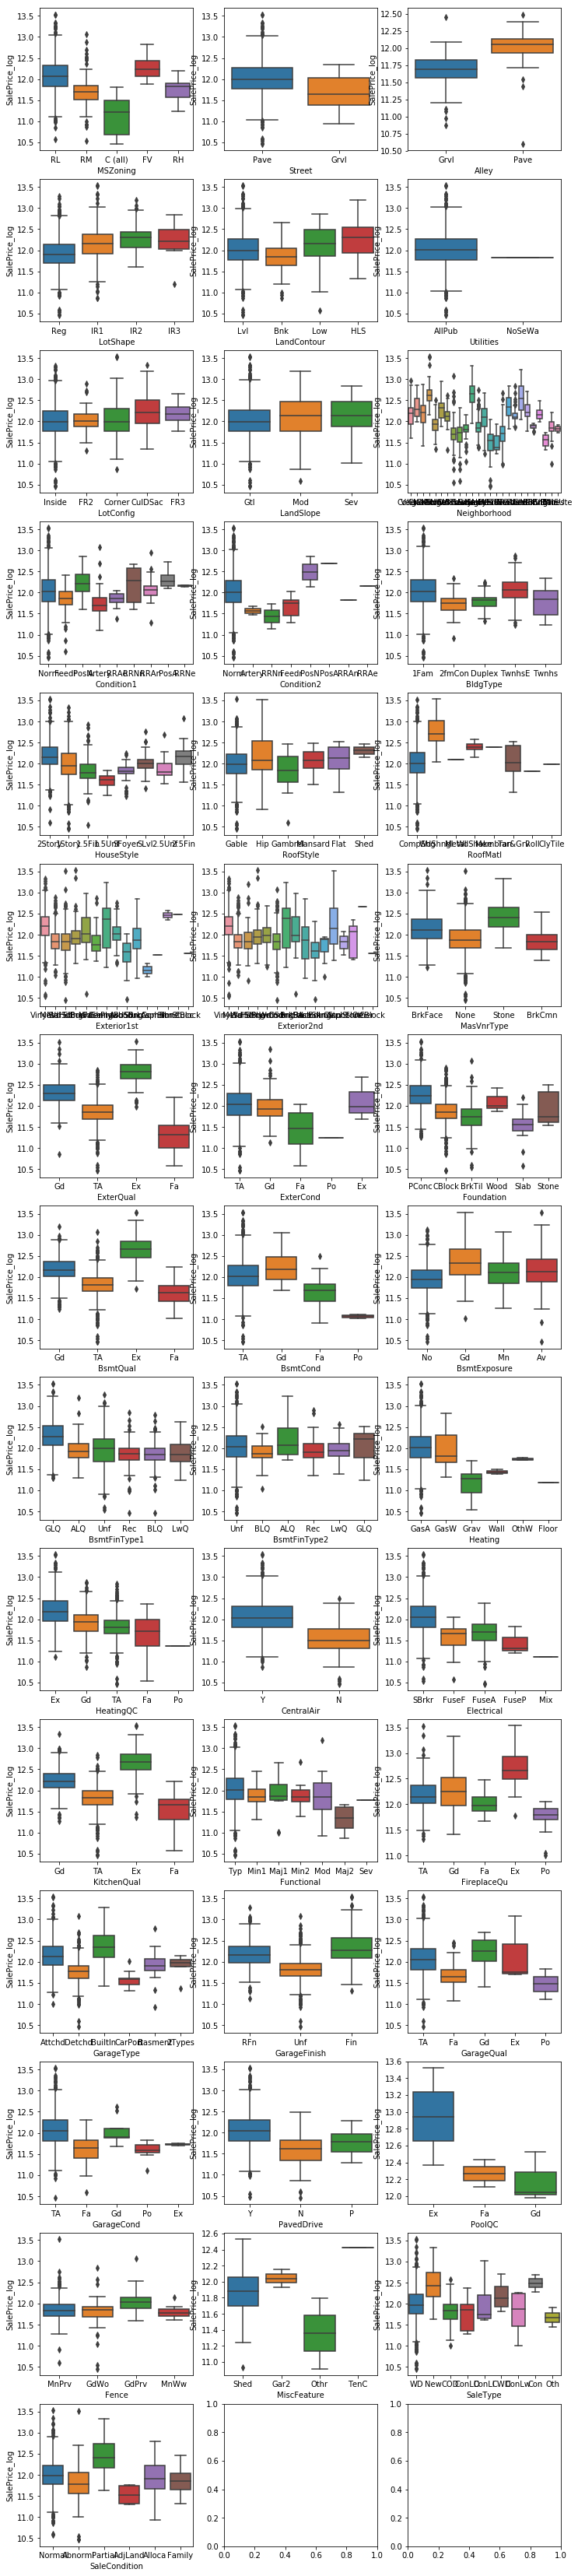

In [18]:
nr_rows = 15
nr_cols = 3
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*4))
for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(categorical):
            sns.boxplot(x=categorical[i], y='SalePrice_log', data=train, ax = axs[r][c])
        

In [19]:
#观察上图，舍弃弱相关变量
categorical=['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical','KitchenQual', 'SaleType']
train_cat=train_cat[categorical]

- **将分类特征转换为数字形式**

In [20]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [21]:
for df in [train_cat, test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4

#### 新分类特征：
- *MSZ_num*
- *NbHd_num*
- *Cond2_num*
- *Mas_num*
- *ExtQ_num*
- *BsQ_num*
- *CA_num*
- *Elc_num*
- *KiQ_num*
- *SlTy_num*

In [22]:
new_cols_cat = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

In [23]:
train_num

,SalePrice_log,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt
0,12.247694,208500,7,1710,548,856,2,2003
1,12.109011,181500,6,1262,460,1262,2,1976
2,12.317167,223500,7,1786,608,920,2,2001
3,11.849398,140000,7,1717,642,756,1,1915
4,12.429216,250000,8,2198,836,1145,2,2000
5,11.870600,143000,5,1362,480,796,1,1993
6,12.634603,307000,8,1694,636,1686,2,2004
7,12.206073,200000,7,2090,484,1107,2,1973
8,11.774520,129900,7,1774,468,952,2,1931
9,11.678440,118000,5,1077,205,991,1,1939


In [24]:
df_train=pd.concat([train_num[new_cols_num],train_cat[new_cols_cat],train[['SalePrice','SalePrice_log']]],axis=1)

In [25]:
feats=df_train.columns.drop(['SalePrice','SalePrice_log'])
target='SalePrice_log'
df_test=test[feats].copy()

## 5.EDA和异常值处理

In [26]:
df_train.head(3)

,OverallQual,GarageArea,TotalBsmtSF,FullBath,YearBuilt,MSZ_num,NbHd_num,Cond2_num,Mas_num,ExtQ_num,BsQ_num,CA_num,Elc_num,KiQ_num,SlTy_num,SalePrice,SalePrice_log
0,7,548,856,2,2003,3,2,2,1,3,2,1,2,3,2,208500,12.247694
1,6,460,1262,2,1976,3,2,2,1,2,2,1,2,2,2,181500,12.109011
2,7,608,920,2,2001,3,2,2,1,3,2,1,2,3,2,223500,12.317167


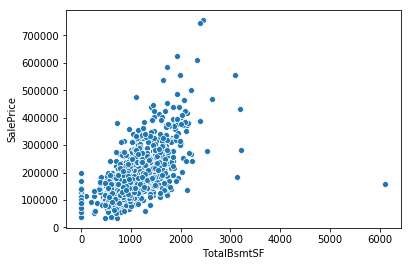

In [27]:
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=df_train)

TotalBsmtSF与SalePrice存在线性关系，但出现一个明显异常点。这里将其简单删除去

In [28]:
outliar=df_train.sort_values(by='TotalBsmtSF',ascending=False)[:1].index
df_train.drop(outliar,inplace=True,axis=0)

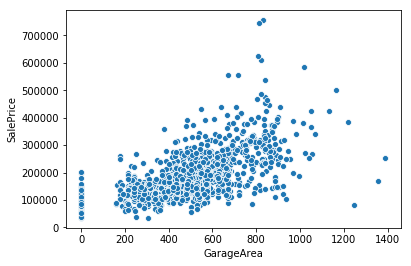

In [29]:
sns.scatterplot(x='GarageArea',y='SalePrice',data=df_train)

## 5. 缺失数据

In [30]:
df_train.isnull().sum().sort_values(ascending=False)

SalePrice_log    0
Cond2_num        0
GarageArea       0
TotalBsmtSF      0
FullBath         0
YearBuilt        0
MSZ_num          0
NbHd_num         0
Mas_num          0
SalePrice        0
ExtQ_num         0
BsQ_num          0
CA_num           0
Elc_num          0
KiQ_num          0
SlTy_num         0
OverallQual      0
dtype: int64

In [31]:
df_test.isnull().sum().sort_values(ascending=False)

TotalBsmtSF    1
GarageArea     1
SlTy_num       0
KiQ_num        0
Elc_num        0
CA_num         0
BsQ_num        0
ExtQ_num       0
Mas_num        0
Cond2_num      0
NbHd_num       0
MSZ_num        0
YearBuilt      0
FullBath       0
OverallQual    0
dtype: int64

训练数据没有缺失，测试数据有2个缺失。缺失值用0填充

In [32]:
df_test['TotalBsmtSF'].fillna(0,inplace=True)
df_test['GarageArea'].fillna(0,inplace=True)

In [33]:
df_test.isnull().sum().sort_values(ascending=False)

SlTy_num       0
KiQ_num        0
Elc_num        0
CA_num         0
BsQ_num        0
ExtQ_num       0
Mas_num        0
Cond2_num      0
NbHd_num       0
MSZ_num        0
YearBuilt      0
FullBath       0
TotalBsmtSF    0
GarageArea     0
OverallQual    0
dtype: int64

没有缺失值，模型建立完成。

## 6. 标准化

检查之前的数字特征，可以看出数值幅度的变化相当大，所以在处理前需要进行标准化。

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
feats=df_train.columns.drop(['SalePrice','SalePrice_log'])
target='SalePrice_log'

In [44]:
df_train[feats]

,OverallQual,GarageArea,TotalBsmtSF,FullBath,YearBuilt,MSZ_num,NbHd_num,Cond2_num,Mas_num,ExtQ_num,BsQ_num,CA_num,Elc_num,KiQ_num,SlTy_num
0,7,548,856,2,2003,3,2,2,1,3,2,1,2,3,2
1,6,460,1262,2,1976,3,2,2,1,2,2,1,2,2,2
2,7,608,920,2,2001,3,2,2,1,3,2,1,2,3,2
3,7,642,756,1,1915,3,2,2,1,2,1,1,2,3,2
4,8,836,1145,2,2000,3,3,2,1,3,2,1,2,3,2
5,5,480,796,1,1993,3,1,2,1,2,2,1,2,2,2
6,8,636,1686,2,2004,3,2,2,2,3,3,1,2,3,2
7,7,484,1107,2,1973,3,2,2,2,2,2,1,2,2,2
8,7,468,952,2,1931,2,1,2,1,2,1,1,1,2,2
9,5,205,991,1,1939,3,1,1,1,2,1,1,2,2,2


In [47]:
scaler=StandardScaler()
x=scaler.fit_transform(df_train[feats].values)
df_test_sc=scaler.fit_transform(df_test[feats].values)
y=df_train[target].values


c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [48]:
y

array([12.24769432, 12.10901093, 12.31716669, ..., 12.49312952,
       11.86446223, 11.90158345])

## 7.模拟数据

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [49]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state= 0)
scores=cross_val_score(LinearRegression(),X_train,y_train,scoring ="neg_mean_squared_error",cv=5)

clfs={LinearRegression():{'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]},
     Ridge():{'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]},
     Lasso():{'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]},
     RandomForestRegressor():{'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] },
    }
for clf in clfs:
    grid_clf=GridSearchCV(clf,clfs[clf],cv=5,verbose=1)
    grid_clf.fit(X_train,y_train)
    score=grid_clf.predict(X_test)
    

In [50]:
lasso=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.001, warm_start=False)

lasso.fit(x,y)

pred=lasso.predict(df_test_sc)

导入测试数据，并将数据中的NAN设为0

In [51]:
result=pd.DataFrame()
result['Id']=test['Id']
result['SalePrice']=np.exp(pred)


In [52]:
result.to_csv('./sale_price.csv',index=False)